In [640]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot as up

In [641]:
tower2p1_events=pd.read_csv("pulse_out/Tower2p1_event_info.csv") #contains reconstruction information
pulses_tower2p1=up.concatenate(["pulse_out/Run352044_tower2p1.root:tree"],library='np')['samples'] #pulses
event_nums_tower2p1=up.concatenate(["pulse_out/Run352044_tower2p1.root:tree"],library='np')['event_number'] #event numbers to connect pulses to reconstruction info

ADC2mV=8.0108642578125e-02 ##this number should be checked with up-to-date front end board readings, but is fine for now

In [642]:
tower2p1_events

,Channel,Time,CoincTime,NumPulses,OFdelay,OFChi2,Energy,Baseline,MaxToBaseline,Run,PCANorm,event_number,BaselineSlope,SingleTrigger
0,54,1018.808,1015.720415,1,3.119665,3.511851,2617.897933,-5949.946025,1135.256388,352044,4.796232,81146,-0.004776,False
1,53,1029.120,1026.040443,1,3.119646,959.445237,1291.883245,-3041.182805,616.774846,352044,16.963644,81911,-0.000647,True
2,58,1056.312,1053.235369,1,3.086841,10.635230,2600.413432,-3019.474859,1154.465551,352044,14.263034,84090,-0.004409,True
3,55,1060.072,1057.011309,1,3.070154,0.177860,737.921289,-3309.880651,198.861516,352044,10.408411,84367,-0.002333,True
4,56,1067.584,1064.502041,1,3.122515,1.473148,1424.047190,-2917.889409,584.885412,352044,1.821491,85011,-0.000906,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24858,59,128172.264,128169.191868,1,3.090579,8.643130,2336.963051,-4723.471242,1099.356252,352044,11.374310,10152655,-0.002778,True
24859,64,128188.112,128185.029504,1,3.123739,0.686072,825.788777,-6597.101735,357.279348,352044,-0.920750,10153787,-0.002088,True
24860,62,128193.784,128190.698521,1,3.115107,1.280897,1114.787370,-3414.805634,669.562561,352044,-0.708036,10154324,-0.001870,True
24861,61,128194.640,128191.566482,1,3.092249,2.601401,662.462041,-4403.333359,308.580093,352044,-0.435548,10154390,-0.000717,True


In [1510]:
tower2p1_events["Channel"].unique()

array([54, 53, 58, 55, 56, 62, 61, 65, 64, 57, 60, 59, 63])

In [643]:
CHANNEL=60 #hard-coding this for now...

In [644]:
file=open("average_pulse_dump/Channel00"+str(CHANNEL)+"_AveragePulse.txt")
for line in file:
    parse=line.replace("fData  ","")
    parse=parse.replace("\n","")
    splits=parse.split(" ")
    avg_pulse=np.array(splits,dtype=float)
    break

cleaned_avg_pulse=(avg_pulse-np.mean(avg_pulse[0:50]))/np.max(avg_pulse-np.mean(avg_pulse[0:50]))

Text(0, 0.5, 'Pulse Amplitude: Correlates to E')

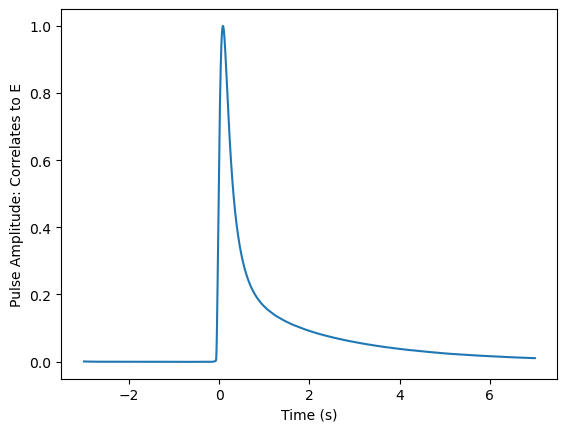

In [645]:
#check out what normalized average pulse for channel 60 is

fully_sampled_times=np.linspace(-3,7,10000) #seconds

plt.plot(fully_sampled_times,cleaned_avg_pulse)

plt.xlabel("Time (s)")
plt.ylabel("Pulse Amplitude: Correlates to E")

In [646]:
THIS_PULSE=8272 #pulse we'll focus on, to get nODE working

In [647]:
#check info on it...

#how to pass back & forth between event number & pulse id...
tower2p1_events[tower2p1_events['event_number']==event_nums_tower2p1[THIS_PULSE]]

,Channel,Time,CoincTime,NumPulses,OFdelay,OFChi2,Energy,Baseline,MaxToBaseline,Run,PCANorm,event_number,BaselineSlope,SingleTrigger
8272,60,43488.616,43485.538606,1,3.079257,4.561317,1123.404947,-4594.086314,390.785838,352044,0.430006,3448536,0.001447,True


In [648]:
THIS_ENERGY=tower2p1_events[tower2p1_events['event_number']==event_nums_tower2p1[THIS_PULSE]].iloc[0]['Energy']

1123.4049474985482  keV


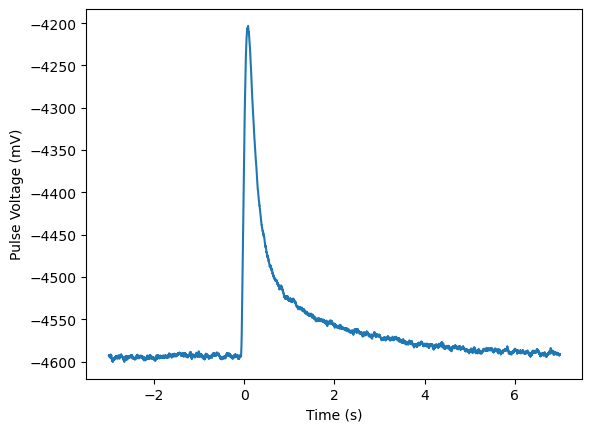

In [649]:
plt.plot(np.linspace(-3,7,10000),ADC2mV*pulses_tower2p1[THIS_PULSE])

plt.xlabel("Time (s)")
plt.ylabel("Pulse Voltage (mV)")

print(THIS_ENERGY, " keV")

1123.4049474985482  keV


(-0.1, 0.1)

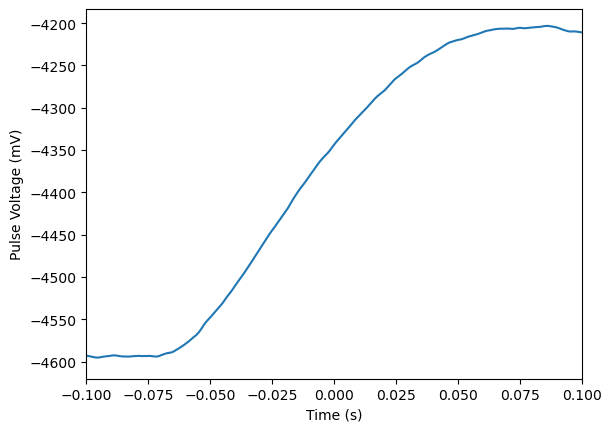

In [650]:
plt.plot(np.linspace(-3,7,10000),ADC2mV*pulses_tower2p1[THIS_PULSE])

plt.xlabel("Time (s)")
plt.ylabel("Pulse Voltage (mV)")

print(THIS_ENERGY, " keV")

plt.xlim([-0.1,0.1])

In [651]:
### feel free to normalize the pulse, e.g. correct for the baseline offset, and make overall amplitude ~0.5

###can start by setting initial condition at time 0, but we should think about how to fine-tune for small time offsets:
### could be grid-search, add differentiable parameter
# this will also be easier when we move beyond 1 pulse to fitting many pulses simulatenously

#initial conditions: should be (0, Energy, 0)
#                               ^    ^     ^
#                               |    |     |
#                               |    |     \- this variable is an extra with no clear interpretation, but can assist in modelling
#                               |    \- this variable models the energy: has initial condition from calibration
#                               \- this variable models the observed pulse, and is the only one entering into the loss
#start off with just our usual MSE-loss between predicted and observed

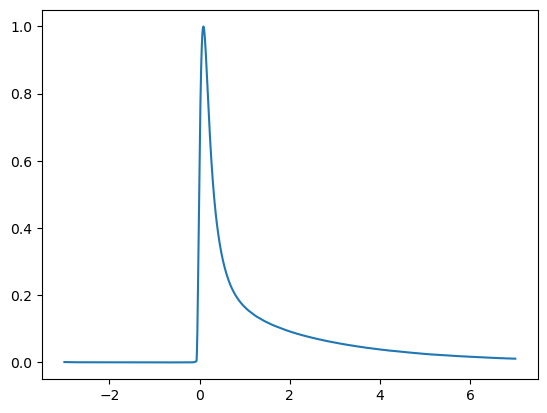

In [716]:
fully_sampled_times=np.linspace(-3,7,10000) #seconds

plt.plot(fully_sampled_times,cleaned_avg_pulse)

In [717]:
df = pd.DataFrame({"Times": fully_sampled_times, "Energy": cleaned_avg_pulse })
df

,Times,Energy
0,-3.000,0.000111
1,-2.999,0.000111
2,-2.998,0.000111
3,-2.997,0.000137
4,-2.996,0.000111
...,...,...
9995,6.996,0.010049
9996,6.997,0.010049
9997,6.998,0.010049
9998,6.999,0.010023


In [924]:
df.to_csv('file1.csv')

In [912]:
import numpy as np 
import pandas as pd 

import optax
import matplotlib.pyplot as plt
from typing import List
import equinox as eqx
import jax
import jax.numpy as jnp
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax

In [1232]:
energies = jnp.array(df["Energy"])
time = jnp.array(df["Times"])

In [1233]:
time = time[2900:]
energies = energies[2900:]

In [1241]:
length = len(energies)
z_s = np.linspace(0, 4, length)

In [1443]:
class LinearFunction(eqx.Module):
    layers: list

    def __init__(self, key): 
        key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 7)
        self.layers = [eqx.nn.Linear(3,6, key = key1, use_bias=True), 
                       eqx.nn.Linear(6,3, key = key1, use_bias=True)] 
    def __call__(self, t, y, *args):
       # print("DEBUG", t,y)
        for layer in self.layers[:-1]:
            y = jax.nn.tanh(layer(y))
        y = self.layers[-1](y)

       # print("DEBUG2", y)
        return y

In [1446]:
vars = [0.0, 10, 0]

In [1447]:
def model_to_loss(model, y_s, z_s, t_s):
    # Solve the differential equation
    
   # print(type(t_s))
    #print("MODELTOLOSS", y_s[0], z_s[0], t_s[len[t_s]])
    solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(model),
        diffrax.Tsit5(),
        t0=float(t_s[0]),
        t1=float(t_s[-1]),
        dt0=0.009,
        y0=jnp.array(vars, dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(t_s)),
    )
    
    y = solutions.ys[:length-1, 0]
    a =  solutions.ys[:length-1, 1]
    b =  solutions.ys[:length-1, 2]
     
   # print(y)

    
    # Use nan_to_num to handle NaNs
    y = jnp.nan_to_num(y, nan=0.0)
   
   
    # Calculate squared differences for the loss
    y_diff = ((y - y_s[:length-1]) ** 2)
    #z_diff = (z - z_s[:N_SAMPLES-1]) ** 2
   # print(jnp.mean(y_diff) + jnp.mean(z_diff))
   # return jnp.sqrt(jnp.mean(y_diff))

   # Predicted outputs
    y = solutions.ys[:length - 1, 0]
    all_outputs = solutions.ys

   
    y_diff = (y - y_s[:length - 1]) ** 2
    squared_loss = jnp.mean(y_diff)

   
    zero_input = jnp.zeros_like(all_outputs[0])
    zero_output = model(0, zero_input)  
    equilibrium_loss = jnp.mean(jnp.abs(zero_output) ** 2)

   
    final_output = all_outputs[-1]
    end_loss = jnp.mean(jnp.abs(final_output))

    N_BATCH = len(t_s) 
    total_loss = (squared_loss + equilibrium_loss)
    return total_loss

In [1464]:
model_to_loss_and_grad = eqx.filter_value_and_grad(model_to_loss)
opt = optax.rmsprop(learning_rate=0.004)
key = jax.random.PRNGKey(41)
key, subkey = jax.random.split(key, 2)
"""def custom_schedule(step):
    # Decrease learning rate as the step increases
    return jnp.maximum(0.001, 0.009 * (0.90 ** (step / 10000000)))  # Cap at 0.001

opt = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_schedule(custom_schedule)
)"""


def make_step(m, opt_s, y_s, z_s, t_s):
    loss, grad = model_to_loss_and_grad(eqx.filter(m, eqx.is_inexact_array), y_s, z_s, t_s)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss

loss_history = []
MODEL = LinearFunction(subkey)
best_loss = float('inf')
opt_state = opt.init(eqx.filter(MODEL, eqx.is_array))
for epoch in range(50000):
    MODEL, opt_state, loss = make_step(MODEL, opt_state, energies, z_s, time)
    loss_history.append(loss)

    
    if loss < best_loss:
        best_loss = loss
        best_weights = eqx.tree_serialise_leaves("best_model.eqx", MODEL)
    
    if epoch % 100 == 0:  # Log every 100 epochs
        print(f"Epoch {epoch}, Loss {loss}")


/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_50935/2758507836.py:12: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array(vars, dtype=jnp.float64),


Epoch 0, Loss 3.073317527770996
Epoch 100, Loss 0.04546255245804787
Epoch 200, Loss 0.04206155613064766
Epoch 300, Loss 0.04066668078303337
Epoch 400, Loss 0.03921359032392502
Epoch 500, Loss 0.037373896688222885
Epoch 600, Loss 0.03340001031756401
Epoch 700, Loss 0.027093030512332916
Epoch 800, Loss 0.023061595857143402
Epoch 900, Loss 0.019526081159710884
Epoch 1000, Loss 0.016470905393362045
Epoch 1100, Loss 0.013420959934592247
Epoch 1200, Loss 0.011056806892156601
Epoch 1300, Loss 0.009393283165991306
Epoch 1400, Loss 0.008075760677456856
Epoch 1500, Loss 0.006661329884082079
Epoch 1600, Loss 0.005533890333026648
Epoch 1700, Loss 0.005095296539366245
Epoch 1800, Loss 0.004244225565344095
Epoch 1900, Loss 0.003612367669120431
Epoch 2000, Loss 0.003235591808333993
Epoch 2100, Loss 0.0029684514738619328
Epoch 2200, Loss 0.0024633617140352726
Epoch 2300, Loss 0.002229409758001566
Epoch 2400, Loss 0.001940519898198545
Epoch 2500, Loss 0.0019866719376295805
Epoch 2600, Loss 0.0017078957

In [1470]:
for epoch in range(10000):
    MODEL, opt_state, loss = make_step(MODEL, opt_state, energies, z_s, time)
    loss_history.append(loss)

    
    if loss < best_loss:
        best_loss = loss
        best_weights = eqx.tree_serialise_leaves("best_model.eqx", MODEL)
    
    if epoch % 100 == 0:  # Log every 100 epochs
        print(f"Epoch {epoch}, Loss {loss}")

/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_50935/2758507836.py:12: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array(vars, dtype=jnp.float64),


Epoch 0, Loss 0.00023465516278520226
Epoch 100, Loss 0.00031770230270922184
Epoch 200, Loss 0.00038895176840014756
Epoch 300, Loss 0.0003936314315069467
Epoch 400, Loss 0.0003469141374807805
Epoch 500, Loss 0.00029855186585336924
Epoch 600, Loss 0.0002667162043508142
Epoch 700, Loss 0.00023990171030163765
Epoch 800, Loss 0.00021563522750511765
Epoch 900, Loss 0.0001939745561685413
Epoch 1000, Loss 0.00017942677368409932
Epoch 1100, Loss 0.000170741172041744
Epoch 1200, Loss 0.0001681562134763226
Epoch 1300, Loss 0.00017071064212359488
Epoch 1400, Loss 0.00017660146113485098
Epoch 1500, Loss 0.00018502070452086627
Epoch 1600, Loss 0.00019541659276001155
Epoch 1700, Loss 0.00020533648785203695
Epoch 1800, Loss 0.00021225101954769343
Epoch 1900, Loss 0.00021657452452927828
Epoch 2000, Loss 0.00021705683320760727
Epoch 2100, Loss 0.00021266598196234554
Epoch 2200, Loss 0.00020410525030456483
Epoch 2300, Loss 0.00019206425349693745
Epoch 2400, Loss 0.00017962999118026346
Epoch 2500, Loss 0.

In [1471]:
time

Array([-0.09970997, -0.09870987, -0.09770977, ...,  6.9979997 ,
        6.999     ,  7.        ], dtype=float32)

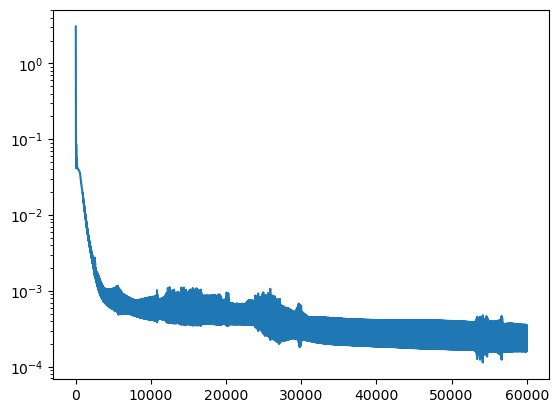

In [1472]:
plt.plot(loss_history)
plt.yscale('log')

In [1473]:
solutions = diffrax.diffeqsolve(
        diffrax.ODETerm(MODEL),
        diffrax.Tsit5(),
        t0=float(time[0]),
        t1=float(time[-1]),
        dt0=0.005,
        y0=jnp.array(vars, dtype=jnp.float64),  
        stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
        saveat=diffrax.SaveAt(ts=jnp.sort(time)),
    )
solutions.ys[:, 0]

/var/folders/wr/p4g_vhcn34g6101bsy9rmsd40000gn/T/ipykernel_50935/1539223643.py:7: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  y0=jnp.array(vars, dtype=jnp.float64),


Array([0.        , 0.00226442, 0.00454178, ..., 0.00867189, 0.0086601 ,
       0.00864831], dtype=float32)

In [1474]:
min(loss_history)

Array(0.00011387, dtype=float32)

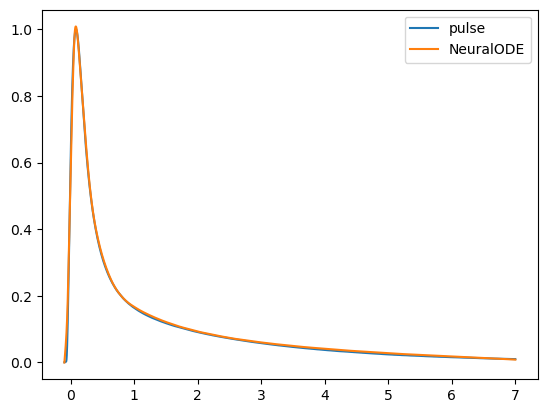

In [1494]:
plt.plot(time, energies, label = "pulse")
plt.plot(time, solutions.ys[:, 0], label = "NeuralODE")
#plt.plot(time, energies-solutions.ys[:, 0])

plt.legend()


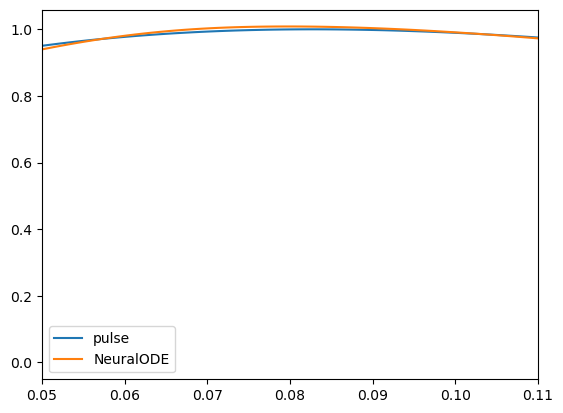

In [1509]:
plt.plot(time, energies, label = "pulse")
plt.plot(time, solutions.ys[:, 0], label = "NeuralODE")
#plt.plot(time, energies-solutions.ys[:, 0])
plt.xlim(0.05, 0.11)
plt.legend()

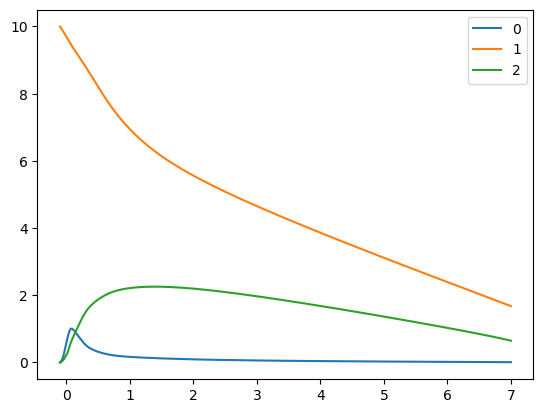

In [1505]:
plt.plot(time, solutions.ys[:, 0], label = "0")
plt.plot(time, solutions.ys[:, 1], label = "1")
plt.plot(time, solutions.ys[:, 2], label = "2")


plt.legend()

(-0.1, 10.0)

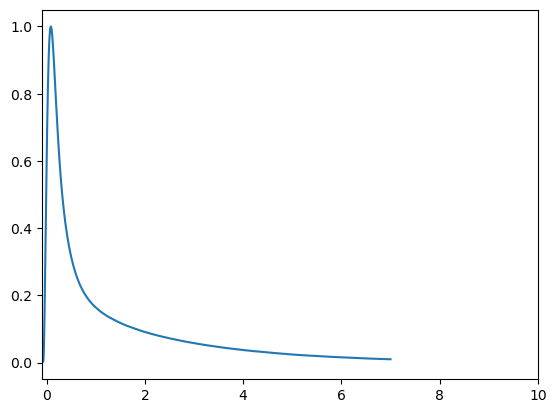

In [1402]:
plt.plot(time, energies)
plt.xlim(-0.1, 10)

In [1503]:
x = np.random.rand(4, 5)
x.shape

(4, 5)